<a href="https://colab.research.google.com/github/kwcooper/CL_neuromatch/blob/main/continual_learning_neuromatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Neuromatch Academy: Week ?, Day ?, Tutorial ?
# Continual Learning

__Content creators:__ [Keiland Cooper](http://kwcooper.xyz), Name Surname


__Content reviewers:__ Name Surname, Name Surname. This includes both reviewers and editors. Add reviewers first then editors (paper-like seniority :) ).


---
#Tutorial Objectives

Use a line (---) separator from title block to objectives. You should briefly introduce your content here in a few sentences. In this tutorial, you will learn what a waxed notebook should look like. **You should make sure the notebook runs from start to finish when done waxing (do restart and run all and make sure there are no errors)**

Then have a few specific objectives for this tutorial:
*   Objective A
*   Objective B
*   Objective C



---
# Setup

In [14]:
# Imports

# Import only the libraries/objects that you use in this tutorial. 

# If any external library has to be installed, !pip install library --quiet
# follow this order: numpy>matplotlib. 
# import widgets in hidden Figure settings cell

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F



In [3]:
#@title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [15]:
#@title Configure PyTorch

# PyTorch Configuration
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)

if not torch.cuda.is_available():
  print('For quicker runtime, add GPU at Runtime -> Change runtime type -> Hardware accelerator -> GPU')

else:
  # switch to False to use CPU
  use_cuda = True

  use_cuda = use_cuda and torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu");
  
torch.manual_seed(1);

Torch 1.8.1+cu101 CUDA 10.1


In [31]:
#@title Dataloader Helper functions

# We need a more permanate solution for this... 
# https://github.com/pytorch/vision/issues/1938

!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

from torchvision.datasets import MNIST
from torchvision import transforms

mnist_train = MNIST('./', download=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                    ]), train=True)
mnist_test = MNIST('./', download=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                    ]), train=False)

def load_mnist(verbose=False):
    '''
    Helper function to maintain compatability with
    previous MNIST dataloaders in CLAI COLAB

    - KWC
    '''
    if verbose: 
      print(mnist_train.targets.shape)
      print(mnist_train.data.shape)

      print(mnist_test.targets.shape)
      print(mnist_test.data.shape)
    return mnist_train.data, mnist_train.targets, \
           mnist_test.data, mnist_test.targets

--2021-05-06 12:40:42--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-05-06 12:40:42--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.3’

MNIST.tar.gz.3          [            <=>     ]  33.20M  6.50MB/s    in 5.4s    

2021-05-06 12:40:49 (6.20 MB/s) - ‘MNIST.tar.gz.3’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

In [4]:
#@title Helper functions

# If any helper functions you want to hide for clarity, add here
# If helper code depends on libraries that aren't used elsewhere,
# import those libaries here, rather than in the main import cell

# a very silly example:
def multiply_array(x, c):
  """Multiply every element in an array by a provided value

  Args:
    x (ndarray): An array of shape (N,) 
    c (scalar): multiplicative factor

  Returns:
    ndarray: output of the multiplication 
  """

  y = x * c

  return y

def plotting_z(z):
  """This function multiplies every element in an array by a provided value

  Args:
    z (ndarray): neural activity over time, shape (T, ) where T is number of timesteps
  
   """

  fig, ax = plt.subplots()

  ax.plot(z)
  ax.set(
       xlabel='Time (s)',
       ylabel='Z',
       title='Neural activity over time'
      
   )

---

# Section 1: Introduction to continual learning & the catastrophic forgetting problem

In [ ]:
#@title Video 1: Video 1 Name
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video


Video available at https://youtu.be/


Text about the first concept. Don't make too long to reduce reading times during tutorial (extra text for later reference can go in appendix)

## Section 1.1: Subsection header if you want one

Whatever text you want can go here.

x_train dim and type:  torch.Size([60000, 1, 28, 28]) torch.uint8
t_train dim and type:  torch.Size([60000]) torch.int64
x_test dim and type:  torch.Size([10000, 1, 28, 28]) torch.uint8
t_test dim and type:  torch.Size([10000]) torch.int64


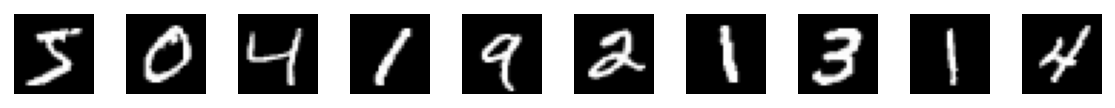

In [51]:
x_train, t_train, x_test, t_test = load_mnist()

# clean up to above and make functions

x_train = torch.unsqueeze(x_train, 1)
x_test = torch.unsqueeze(x_test, 1)

print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", t_train.shape, t_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", t_test.shape, t_test.dtype)

# Plot the MNIST data
nPlots = 10
f, axarr = plt.subplots(1,nPlots)
for ii in range(nPlots):
  axarr[ii].imshow(x_train[ii,0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);


In [ ]:
# test commit

In [53]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [46]:
def train(model, device, x_train, t_train, optimizer, epoch):
    model.train()
    
    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x, y = x_train[start:end], t_train[start:end]
      x, y = x.to(device), y.to(device)
      
      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, x_test, t_test):
    model.eval()
    correct, test_loss = 0, 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_train)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return 100. * correct / len(t_test)

In [52]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 3):
  train(model, device, x_train, t_train, optimizer, epoch)
  #test(model, device, x_test, t_test)

RuntimeError: ignored

### Exercise 1: Helpful exercise name (ex. fitting a linear regression model)

This exercise fits in this subsection so is a level 3 header

Very briefly summarize the exercise here. In this exercise, you will also invoke `multiply_array` which multiplies an array by a scalar

In [1]:
def generic_function(x):
  """Google style doc string. Brief summary of what function does here
  
  Args:
    x (ndarray): An array of shape (N,) that contains blah blah

  Returns:
    ndarray: The output is blah blah
  """
  #################################################
  ## TODO for students: details of what they should do ##
  # Fill out function and remove
  raise NotImplementedError("Student exercise: say what they should have done")
  #################################################
  
  # Have a comment for every line of code they need to write, and when possible have
  # variables written with ellipses where they should fill in or ellipses where they should
  # fill in inputs to functions
  y = multiply_array(..., 5)

  # Another comment because they need to add another line of code
  z = ...

  return z

x = np.array([4, 5, 6])
z = generic_function(x)

# we usually define the plotting function in the hidden Helper Functions
# so students don't have to see a bunch of boilerplate matplotlib code
plotting_z(z)

NameError: ignored

---
__Editor guideline for exercise solution formatting:__
- the presence of # to_remove solution in the first line of solution block
- The absence of the fenced (#####) block that raises a NotImplementedError
- Valid code replacing all ellipses  (...)
- Code that uses or depends on the completed function/lines is uncommented
- Plotting code is indented under a with plt.xkcd(): context manager.
- **All other comments and code should be identical**
---

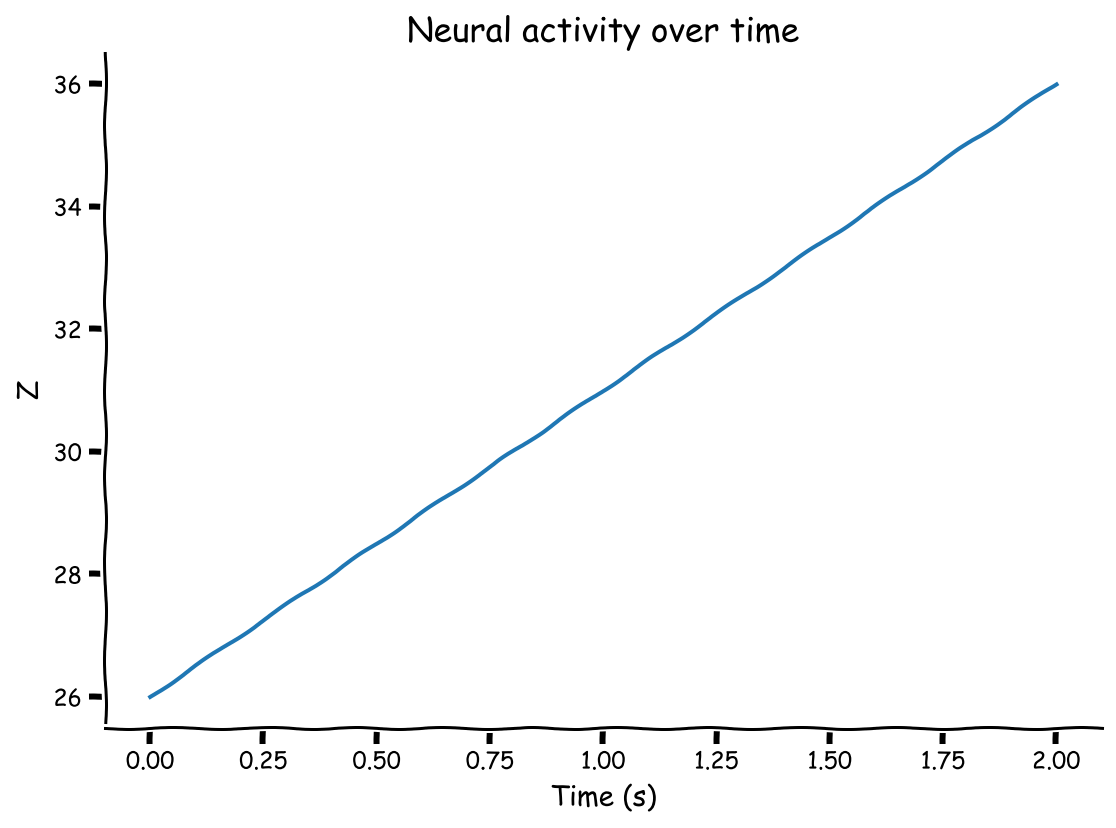

In [ ]:
# to_remove solution
def generic_function(x):
  """Google style doc string. Brief summary of what function does here
  
  Args:
    x (ndarray): An array of shape (N,) that contains blah blah

  Returns:
    ndarray: The output is blah blah
  """

  # Have a comment for every line of code they need to write, and when possible have
  # variables written with ellipses where they should fill in or ellipses where they should
  # fill in inputs to functions
  y = multiply_array(x, 5)

  # Another comment because they need to add another line of code
  z = y + 6

  return z

x = np.array([4, 5, 6])
z = generic_function(x)

# we usually define the plotting function in the hidden Helper Functions
# so students don't have to see a bunch of boilerplate matplotlib code
# xkcd style for solution plot
with plt.xkcd():  
  plotting_z(z)

### Interactive Demo: Name of demo

Here, we will demonstrate how to create a widget if you would like to use a widget to demonstrate something. Make sure the use a @title cell and hide the contents by default, because the code to make the widget is often pretty ugly and not important for the students to see. Also, we recommend giving specific guidance for what students should look at with widget/what questions they're trying to answer so it's not just pointless twiddling.

If the widget makes use of a function that must be completed as part of an exercise, you may want to re-implement the correct version of the function inside the widget cell, so that it is useful for a student who got completely stuck.


In [7]:
#@title 

#@markdown Make sure you execute this cell to enable the widget!

x = np.arange(-10, 11, 0.1)

def gaussian(x, mu, sigma):
  px = np.exp(-1 / 2 / sigma**2 * (mu - x) ** 2)
  px = px / px.sum()
  return px

@widgets.interact
def plot_gaussian(mean=(-10, 10, .5), std=(.5, 10, .5)):
  plt.plot(x, gaussian(x, mean, std))


interactive(children=(FloatSlider(value=0.0, description='mean', max=10.0, min=-10.0, step=0.5), FloatSlider(v…

In [ ]:
# to_remove explanation

"""
Discussion: Write a dicussion about/answers to any open-ended questions you pose (either about a demo or elsewhere)

You can write a paragraph or two of nice didactic text
within a single comment. 
""";

__Editor guideline:__ note that the form header for the cell above is __to_remove explanation__, not __to_remove solution__.

maybe some more text about what exercises showed (if helpful). 
The Gaussian is: 
- bumpy in the middle
- symmetric
- almighty

## Section 1.2: Name

### Exercise 2: Name

---
# Section 2: Another content section

Separate with lines and add more content here! Depending on how the videos were created, you may or may not have a separate video for each section

In [ ]:
#@title Video 2: Video 2 Name
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Video available at https://youtu.be/


## Exercise 3: Name

This exercise is in this section (not in a subsection) so has a level 2 header

---
# Summary

Have a summary of what they learned with specific points.

* Specific point A

* Specific point B


---
# Bonus

Add extra text that you want students to have for reference later but that will make reading times too long during tutorials

In [ ]:
# Free up resources when done :)

import os, signal
os.kill(os.getpid(), signal.SIGKILL)